<a href="https://colab.research.google.com/github/EduardoAve/An-lisis-descriptivo-de-matr-cula/blob/main/analisis_descriptivo_CIEAVC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis Descriptivo de Población Estudiantil
## Sedes Educativas CIEAVC (2019 - 2025)

Este notebook realiza un análisis descriptivo de la población estudiantil matriculada en 50 sedes educativas, utilizando datos del **SIMAT** (matrícula, 2019-2025) y **SIMPADE** (deserción, 2020-2025).

### Variables analizadas:
- Estrato socioeconómico
- Edad
- Género
- Población víctima del conflicto
- Discapacidad
- Etnia
- Grado y nivel educativo
- Repitencia
- Cabeza de familia y beneficiario madre cabeza de familia
- Índice de deserción (SIMPADE)

---
## 1. Carga de datos y configuración

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# --- Paleta de colores Viridis personalizada ---
palette = [
    "#440154FF", "#481567FF", "#482677FF", "#453781FF", "#404788FF",
    "#39568CFF", "#33638DFF", "#2D708EFF", "#287D8EFF", "#238A8DFF",
    "#1F968BFF", "#20A387FF", "#29AF7FFF", "#3CBB75FF", "#55C667FF",
    "#73D055FF", "#95D840FF", "#B8DE29FF", "#DCE319FF", "#FDE725FF",
]

# Configuración global de estilo
sns.set_theme(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

# --- Carga de datos ---
SIMAT = pd.read_excel("/content/drive/MyDrive/reportes 2026/reporte NIKI 2/DATASET_SIMAT_CIEAVC_2019_2025.xlsx")
SIMPADE = pd.read_excel("/content/drive/MyDrive/reportes 2026/reporte NIKI 2/DATASET_SIMPADE_CIEAVC_2019_2025.xlsx")

print(f"SIMAT: {SIMAT.shape[0]:,} registros, {SIMAT.shape[1]} columnas")
print(f"SIMPADE: {SIMPADE.shape[0]:,} registros, {SIMPADE.shape[1]} columnas")
print(f"\nAños SIMAT: {sorted(SIMAT['ANO_INF'].unique())}")
print(f"Años SIMPADE: {sorted(SIMPADE['ANNO_INF'].unique())}")

SIMAT: 244,831 registros, 78 columnas
SIMPADE: 9,958 registros, 161 columnas

Años SIMAT: [np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Años SIMPADE: [np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
## 2. Transformación y preparación de variables

In [5]:
# ============================================================
# 2.1 EDAD: Calcular desde FECHA_NACIMIENTO hasta 1 de noviembre del ANO_INF
# ============================================================
SIMAT['FECHA_NACIMIENTO'] = pd.to_datetime(SIMAT['FECHA_NACIMIENTO'], errors='coerce')
SIMAT['FECHA_CORTE'] = pd.to_datetime(SIMAT['ANO_INF'].astype(str) + '-11-01')
SIMAT['EDAD'] = pd.to_numeric(
    (SIMAT['FECHA_CORTE'] - SIMAT['FECHA_NACIMIENTO']).dt.days / 365.25,
    errors='coerce'
).round(0).astype('Int64')

# ============================================================
# 2.2 ESTRATO: Recodificar 0 y 9 como 'No aplica'
# ============================================================
SIMAT['ESTRATO_CAT'] = SIMAT['ESTRATO'].apply(
    lambda x: 'No aplica' if x in [0, 9] else f'Estrato {int(x)}' if pd.notna(x) else 'Sin dato'
)

# ============================================================
# 2.3 VÍCTIMA DEL CONFLICTO: 99 = No víctima, resto = Víctima
# ============================================================
SIMAT['VICTIMA'] = SIMAT['POB_VICT_CONF'].apply(
    lambda x: 'No víctima' if x == 99 else 'Víctima' if pd.notna(x) else 'Sin dato'
)

# ============================================================
# 2.4 DISCAPACIDAD: 99 = Sin discapacidad, resto = Con discapacidad
# ============================================================
SIMAT['DISCAPACIDAD'] = SIMAT['TIPO_DISCAPACIDAD'].apply(
    lambda x: 'Sin discapacidad' if x == 99 else 'Con discapacidad' if pd.notna(x) else 'Sin dato'
)

# ============================================================
# 2.5 ETNIA: Clasificar en 4 categorías
# ============================================================
def clasificar_etnia(codigo):
    if pd.isna(codigo):
        return 'Sin dato'
    codigo = int(codigo)
    if codigo == 0:
        return 'No autoreconocimiento'
    elif codigo == 400:
        return 'Rrom'
    elif codigo in [97, 98, 200]:
        return 'Afrodescendiente'
    else:
        return 'Indígena'

SIMAT['ETNIA_CAT'] = SIMAT['ETNIA'].apply(clasificar_etnia)

# ============================================================
# 2.6 NIVEL EDUCATIVO: Agrupar grados
# ============================================================
def clasificar_nivel(grado):
    if pd.isna(grado):
        return 'Sin dato'
    grado = int(grado)
    if grado in [-2, -1, 0]:
        return 'Educación inicial'
    elif 1 <= grado <= 5:
        return 'Básica primaria'
    elif 6 <= grado <= 9:
        return 'Básica secundaria'
    elif grado in [10, 11]:
        return 'Media'
    elif 21 <= grado <= 26:
        return 'Ciclos de adultos'
    elif grado == 99:
        return 'Aceleración del aprendizaje'
    else:
        return 'Otro'

SIMAT['NIVEL_EDUCATIVO'] = SIMAT['GRADO'].apply(clasificar_nivel)

print("Transformaciones completadas exitosamente.")
print(f"\nDistribución de Etnia: {SIMAT['ETNIA_CAT'].value_counts().to_dict()}")
print(f"Distribución de Nivel Educativo: {SIMAT['NIVEL_EDUCATIVO'].value_counts().to_dict()}")

Transformaciones completadas exitosamente.

Distribución de Etnia: {'No autoreconocimiento': 144751, 'Afrodescendiente': 98973, 'Indígena': 1097, 'Rrom': 10}
Distribución de Nivel Educativo: {'Básica primaria': 100196, 'Básica secundaria': 79704, 'Media': 28422, 'Ciclos de adultos': 16426, 'Educación inicial': 15976, 'Aceleración del aprendizaje': 4107}


---
## 3. Funciones auxiliares de visualización

In [6]:
def formato_miles(x, pos):
    """Formato para ejes: 1000 -> 1,000"""
    return f'{int(x):,}'

def grafico_barras(data, x_col, titulo, xlabel, ylabel='Número de estudiantes',
                   orden=None, horizontal=False, color_idx=0, figsize=(12, 6), rotation=0,
                   mostrar_valores=True, ax=None):
    """Gráfico de barras reutilizable con estilo consistente."""
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    conteo = data[x_col].value_counts()
    if orden is not None:
        conteo = conteo.reindex(orden).dropna()

    n_barras = len(conteo)
    colores = [palette[int(i * (len(palette)-1) / max(n_barras-1, 1))] for i in range(n_barras)]

    if horizontal:
        bars = ax.barh(conteo.index.astype(str), conteo.values, color=colores, edgecolor='white')
        ax.set_xlabel(ylabel)
        ax.set_ylabel(xlabel)
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
        if mostrar_valores:
            for bar, val in zip(bars, conteo.values):
                ax.text(val + conteo.max()*0.01, bar.get_y() + bar.get_height()/2,
                        f'{int(val):,}', va='center', fontsize=9)
    else:
        bars = ax.bar(conteo.index.astype(str), conteo.values, color=colores, edgecolor='white')
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
        ax.tick_params(axis='x', rotation=rotation)
        if mostrar_valores:
            for bar, val in zip(bars, conteo.values):
                ax.text(bar.get_x() + bar.get_width()/2, val + conteo.max()*0.01,
                        f'{int(val):,}', ha='center', va='bottom', fontsize=9)

    ax.set_title(titulo, fontsize=14, fontweight='bold', pad=15)
    ax.spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    return ax


def grafico_lineas_temporal(data, variable, titulo, ylabel='Número de estudiantes',
                            ano_col='ANO_INF', figsize=(12, 6), porcentaje=False):
    """Gráfico de líneas para evolución temporal de una variable categórica."""
    fig, ax = plt.subplots(figsize=figsize)

    tabla = data.groupby([ano_col, variable]).size().unstack(fill_value=0)
    if porcentaje:
        tabla = tabla.div(tabla.sum(axis=1), axis=0) * 100
        ylabel = 'Porcentaje (%)'

    n_cats = len(tabla.columns)
    colores = [palette[int(i * (len(palette)-1) / max(n_cats-1, 1))] for i in range(n_cats)]

    for i, col in enumerate(tabla.columns):
        ax.plot(tabla.index, tabla[col], marker='o', linewidth=2.5, markersize=7,
                label=col, color=colores[i])
        # Etiqueta en el último punto
        ultimo_val = tabla[col].iloc[-1]
        if porcentaje:
            ax.annotate(f'{ultimo_val:.1f}%', (tabla.index[-1], ultimo_val),
                        textcoords='offset points', xytext=(10, 0), fontsize=9)
        else:
            ax.annotate(f'{int(ultimo_val):,}', (tabla.index[-1], ultimo_val),
                        textcoords='offset points', xytext=(10, 0), fontsize=9)

    ax.set_title(titulo, fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Año')
    ax.set_ylabel(ylabel)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    ax.set_xticks(sorted(data[ano_col].unique()))
    ax.spines[['top', 'right']].set_visible(False)
    if not porcentaje:
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
    plt.tight_layout()
    plt.show()


def tabla_resumen(data, variable, ano_col='ANO_INF'):
    """Genera tabla resumen con conteos y porcentajes por año."""
    tabla = data.groupby([ano_col, variable]).size().unstack(fill_value=0)
    tabla_pct = tabla.div(tabla.sum(axis=1), axis=0) * 100

    # Combinar conteo y porcentaje
    resultado = pd.DataFrame()
    for col in tabla.columns:
        resultado[f'{col} (n)'] = tabla[col].apply(lambda x: f'{int(x):,}')
        resultado[f'{col} (%)'] = tabla_pct[col].apply(lambda x: f'{x:.1f}%')

    resultado.index.name = 'Año'
    return resultado

print("Funciones de visualización cargadas.")

Funciones de visualización cargadas.


---
## 4. Matrícula total por año

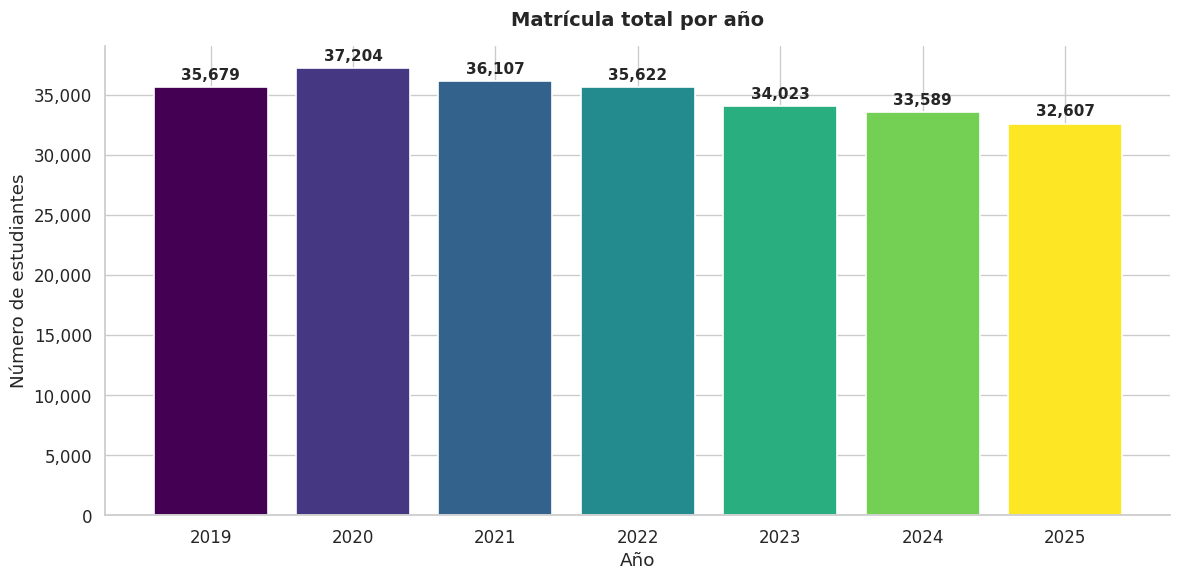


Tabla resumen:


,Total
ANO_INF,
2019,"35,679"
2020,"37,204"
2021,"36,107"
2022,"35,622"
2023,"34,023"
2024,"33,589"
2025,"32,607"


In [7]:
# Matrícula total por año
matricula_anual = SIMAT.groupby('ANO_INF').size().reset_index(name='Total')

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(matricula_anual['ANO_INF'].astype(str), matricula_anual['Total'],
              color=[palette[int(i * (len(palette)-1) / max(len(matricula_anual)-1, 1))]
                     for i in range(len(matricula_anual))],
              edgecolor='white', linewidth=1.2)

for bar, val in zip(bars, matricula_anual['Total']):
    ax.text(bar.get_x() + bar.get_width()/2, val + matricula_anual['Total'].max()*0.01,
            f'{int(val):,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_title('Matrícula total por año', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Año')
ax.set_ylabel('Número de estudiantes')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

print("\nTabla resumen:")
display(matricula_anual.set_index('ANO_INF').style.format({'Total': '{:,}'}))

---
## 5. Distribución por Estrato Socioeconómico

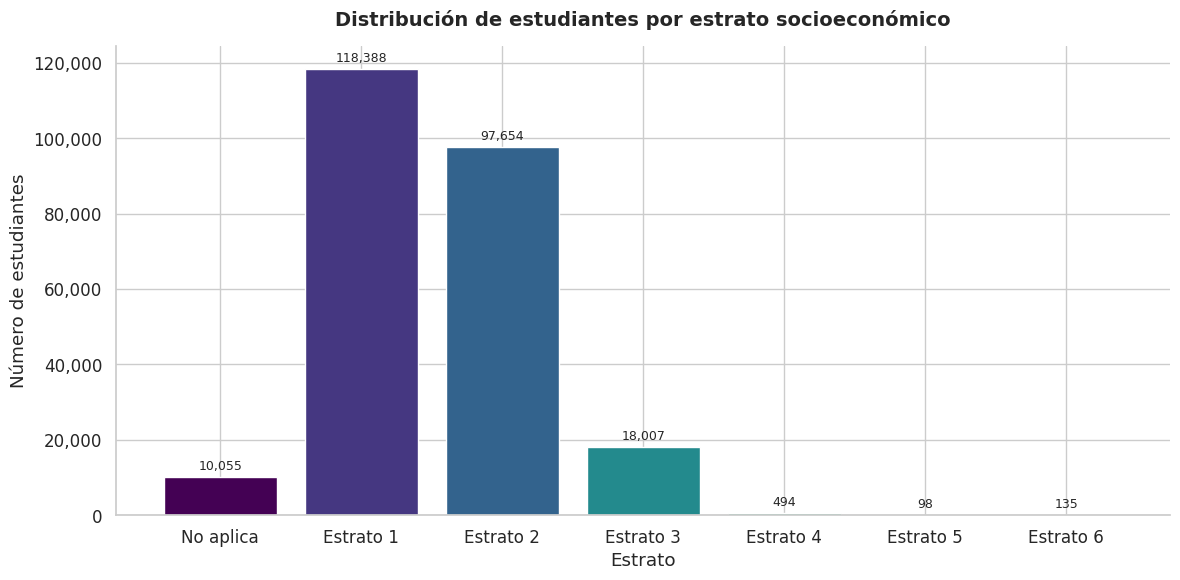


Tabla resumen - Estrato por año:


,Estrato 1 (n),Estrato 1 (%),Estrato 2 (n),Estrato 2 (%),Estrato 3 (n),Estrato 3 (%),Estrato 4 (n),Estrato 4 (%),Estrato 5 (n),Estrato 5 (%),Estrato 6 (n),Estrato 6 (%),No aplica (n),No aplica (%)
Año,,,,,,,,,,,,,,
2019,"17,401",48.8%,"14,403",40.4%,"2,615",7.3%,74,0.2%,18,0.1%,66,0.2%,"1,102",3.1%
2020,"17,970",48.3%,"14,956",40.2%,"2,876",7.7%,72,0.2%,13,0.0%,36,0.1%,"1,281",3.4%
2021,"17,128",47.4%,"14,759",40.9%,"2,783",7.7%,88,0.2%,13,0.0%,10,0.0%,"1,326",3.7%
2022,"17,216",48.3%,"14,148",39.7%,"2,617",7.3%,72,0.2%,16,0.0%,8,0.0%,"1,545",4.3%
2023,"16,670",49.0%,"13,250",38.9%,"2,462",7.2%,61,0.2%,12,0.0%,8,0.0%,"1,560",4.6%
2024,"16,478",49.1%,"13,072",38.9%,"2,309",6.9%,65,0.2%,15,0.0%,5,0.0%,"1,645",4.9%
2025,"15,525",47.6%,"13,066",40.1%,"2,345",7.2%,62,0.2%,11,0.0%,2,0.0%,"1,596",4.9%


In [8]:
# Orden de estratos
orden_estrato = ['No aplica', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']

# --- Gráfico general ---
fig, ax = plt.subplots(figsize=(12, 6))
grafico_barras(SIMAT, 'ESTRATO_CAT', 'Distribución de estudiantes por estrato socioeconómico',
               'Estrato', orden=orden_estrato, ax=ax)
plt.show()

# --- Tabla resumen por año ---
print("\nTabla resumen - Estrato por año:")
display(tabla_resumen(SIMAT, 'ESTRATO_CAT'))

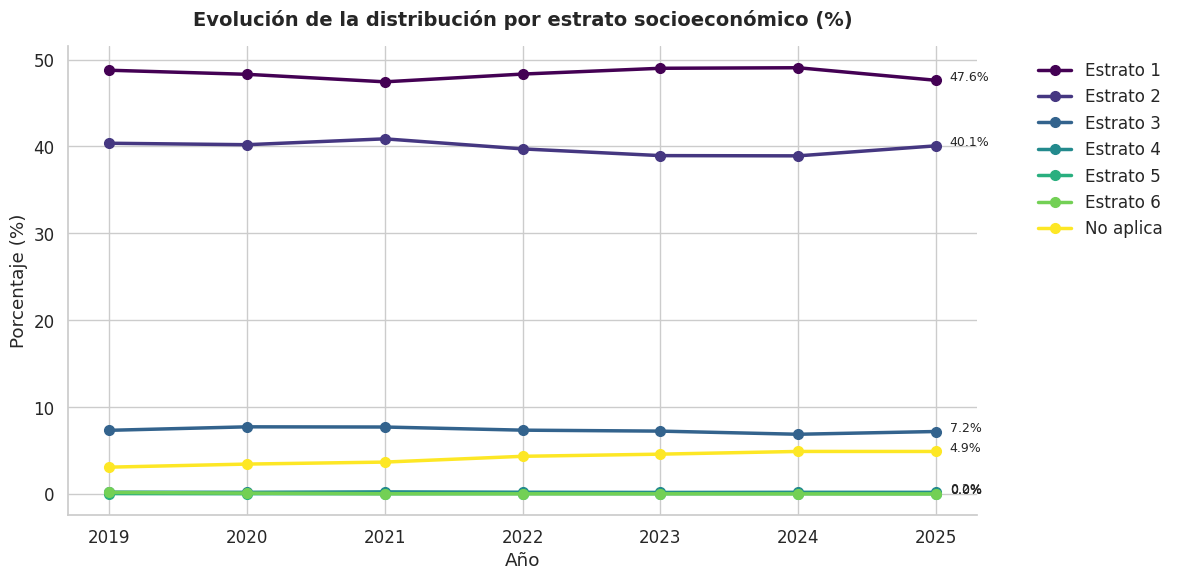

In [9]:
# --- Evolución temporal del estrato (porcentaje) ---
grafico_lineas_temporal(SIMAT, 'ESTRATO_CAT',
                        'Evolución de la distribución por estrato socioeconómico (%)',
                        porcentaje=True)

---
## 6. Distribución por Edad

Estadísticas descriptivas de la edad:
         count       mean       std  min  25%   50%   75%   max
EDAD  244831.0  12.759013  5.587432  4.0  9.0  12.0  15.0  90.0


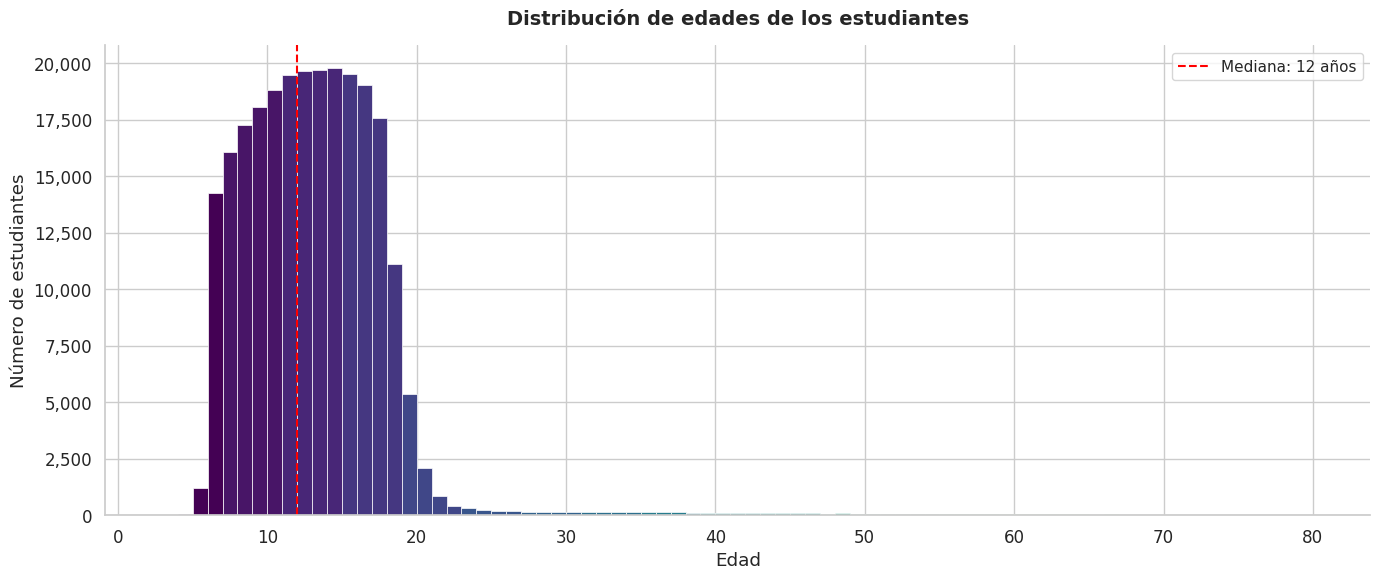

In [10]:
# Estadísticas descriptivas de edad
print("Estadísticas descriptivas de la edad:")
print(SIMAT['EDAD'].describe().to_frame().T.to_string())

# --- Histograma de edades (todos los años) ---
fig, ax = plt.subplots(figsize=(14, 6))
edades_validas = SIMAT['EDAD'].dropna()
edades_validas = edades_validas[(edades_validas >= 3) & (edades_validas <= 80)]  # Filtro razonable

n, bins, patches = ax.hist(edades_validas, bins=range(3, 81), edgecolor='white', linewidth=0.5)
# Colorear barras con la paleta
for i, patch in enumerate(patches):
    color_idx = int(i * (len(palette)-1) / max(len(patches)-1, 1))
    patch.set_facecolor(palette[color_idx])

ax.set_title('Distribución de edades de los estudiantes', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Edad')
ax.set_ylabel('Número de estudiantes')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.spines[['top', 'right']].set_visible(False)

# Línea de mediana
mediana = edades_validas.median()
ax.axvline(mediana, color='red', linestyle='--', linewidth=1.5, label=f'Mediana: {mediana:.0f} años')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

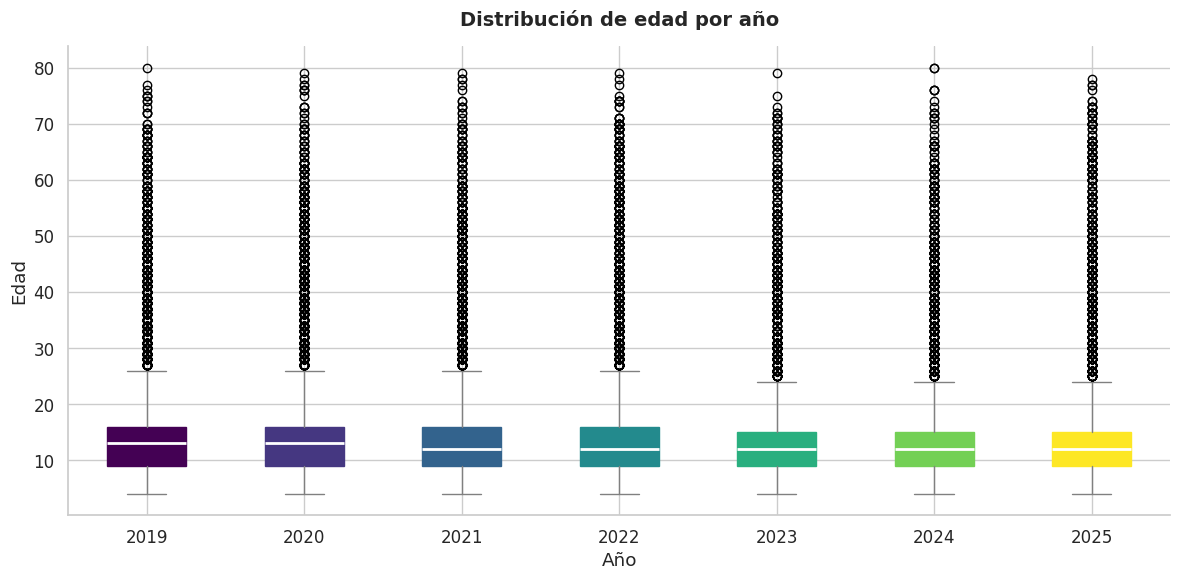


Estadísticas de edad por año:


,N,Media,Desv. Est.,Mín,Q1,Mediana,Q3,Máx
ANO_INF,,,,,,,,
2019,"35,679",12.9,5.7,4.0,9.0,13.0,16.0,80.0
2020,"37,204",13.0,5.8,4.0,9.0,13.0,16.0,79.0
2021,"36,107",12.8,5.5,4.0,9.0,12.0,16.0,81.0
2022,"35,622",12.8,5.8,4.0,9.0,12.0,16.0,83.0
2023,"34,023",12.6,5.2,4.0,9.0,12.0,15.0,90.0
2024,"33,589",12.5,5.3,4.0,9.0,12.0,15.0,82.0
2025,"32,607",12.6,5.6,4.0,9.0,12.0,15.0,85.0


In [11]:
# --- Boxplot de edad por año ---
fig, ax = plt.subplots(figsize=(12, 6))
anos = sorted(SIMAT['ANO_INF'].unique())
data_box = [SIMAT.loc[(SIMAT['ANO_INF'] == a) & (SIMAT['EDAD'].between(3, 80)), 'EDAD'].dropna() for a in anos]

bp = ax.boxplot(data_box, labels=[str(a) for a in anos], patch_artist=True,
                medianprops=dict(color='white', linewidth=2),
                whiskerprops=dict(color='gray'),
                capprops=dict(color='gray'))

n_box = len(bp['boxes'])
for i, box in enumerate(bp['boxes']):
    color_idx = int(i * (len(palette)-1) / max(n_box-1, 1))
    box.set_facecolor(palette[color_idx])
    box.set_edgecolor(palette[color_idx])

ax.set_title('Distribución de edad por año', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Año')
ax.set_ylabel('Edad')
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen de edad por año
print("\nEstadísticas de edad por año:")
tabla_edad = SIMAT.groupby('ANO_INF')['EDAD'].describe()[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
tabla_edad.columns = ['N', 'Media', 'Desv. Est.', 'Mín', 'Q1', 'Mediana', 'Q3', 'Máx']
tabla_edad['N'] = tabla_edad['N'].apply(lambda x: f'{int(x):,}')
tabla_edad[['Media', 'Desv. Est.']] = tabla_edad[['Media', 'Desv. Est.']].round(1)
display(tabla_edad)

---
## 7. Distribución por Género

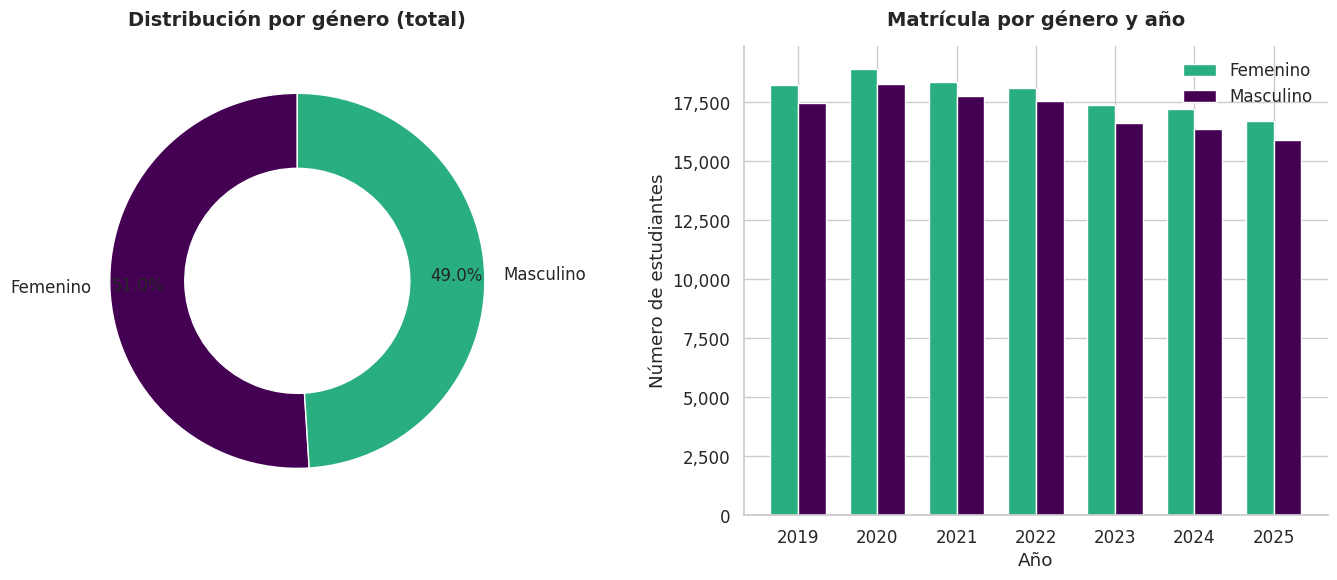


Tabla resumen - Género por año:


,F (n),F (%),M (n),M (%)
Año,,,,
2019,"18,230",51.1%,"17,449",48.9%
2020,"18,915",50.8%,"18,289",49.2%
2021,"18,344",50.8%,"17,763",49.2%
2022,"18,083",50.8%,"17,539",49.2%
2023,"17,386",51.1%,"16,637",48.9%
2024,"17,228",51.3%,"16,361",48.7%
2025,"16,710",51.2%,"15,897",48.8%


In [12]:
# --- Gráfico de torta general ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Torta
genero_conteo = SIMAT['GENERO'].value_counts()
colores_genero = [palette[0], palette[12]]
axes[0].pie(genero_conteo, labels=genero_conteo.index.map({'M': 'Masculino', 'F': 'Femenino'}),
            autopct='%1.1f%%', colors=colores_genero, startangle=90,
            textprops={'fontsize': 12}, pctdistance=0.85,
            wedgeprops=dict(width=0.4, edgecolor='white'))
axes[0].set_title('Distribución por género (total)', fontsize=14, fontweight='bold', pad=15)

# Barras por año
genero_anual = SIMAT.groupby(['ANO_INF', 'GENERO']).size().unstack(fill_value=0)
x = np.arange(len(genero_anual))
w = 0.35
bars1 = axes[1].bar(x - w/2, genero_anual['F'], w, label='Femenino', color=palette[12], edgecolor='white')
bars2 = axes[1].bar(x + w/2, genero_anual['M'], w, label='Masculino', color=palette[0], edgecolor='white')

axes[1].set_title('Matrícula por género y año', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Número de estudiantes')
axes[1].set_xticks(x)
axes[1].set_xticklabels(genero_anual.index.astype(str))
axes[1].legend(frameon=False)
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# Tabla resumen
print("\nTabla resumen - Género por año:")
display(tabla_resumen(SIMAT, 'GENERO'))

---
## 8. Población Víctima del Conflicto

Años con datos válidos de víctimas del conflicto: [2019, 2020, 2021, 2022]
⚠️ Años sin datos válidos (se excluyen del análisis): [np.int64(2023), np.int64(2024), np.int64(2025)]


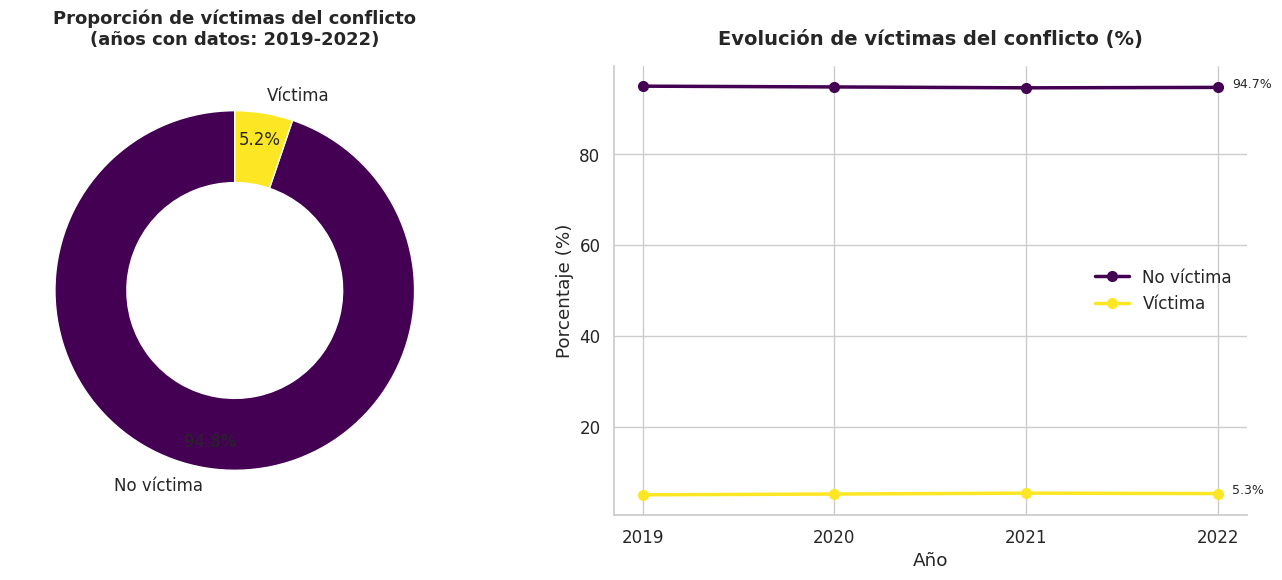


Tabla resumen - Víctimas del conflicto por año (solo años con datos):


,No víctima (n),No víctima (%),Víctima (n),Víctima (%)
Año,,,,
2019,"33,891",95.0%,"1,788",5.0%
2020,"35,276",94.8%,"1,928",5.2%
2021,"34,166",94.6%,"1,941",5.4%
2022,"33,741",94.7%,"1,881",5.3%


In [13]:
# --- Distribución general ---
# Identificar años con datos reales (donde no todo es 'Sin dato')
victima_por_ano = SIMAT.groupby('ANO_INF')['VICTIMA'].value_counts(normalize=True).unstack(fill_value=0)
anos_con_dato = victima_por_ano[victima_por_ano.get('Sin dato', 0) < 0.5].index.tolist()
print(f'Años con datos válidos de víctimas del conflicto: {anos_con_dato}')
if len(anos_con_dato) < len(SIMAT['ANO_INF'].unique()):
    anos_sin = sorted(set(SIMAT['ANO_INF'].unique()) - set(anos_con_dato))
    print(f'⚠️ Años sin datos válidos (se excluyen del análisis): {anos_sin}')

SIMAT_VICT = SIMAT[SIMAT['ANO_INF'].isin(anos_con_dato)].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Torta solo con datos válidos (excluir 'Sin dato')
victima_conteo = SIMAT_VICT['VICTIMA'].value_counts()
victima_conteo = victima_conteo[victima_conteo.index != 'Sin dato']
n_cats_v = len(victima_conteo)
colores_victima = [palette[int(i * (len(palette)-1) / max(n_cats_v-1, 1))] for i in range(n_cats_v)]
axes[0].pie(victima_conteo, labels=victima_conteo.index,
            autopct='%1.1f%%', colors=colores_victima, startangle=90,
            textprops={'fontsize': 12}, pctdistance=0.85,
            wedgeprops=dict(width=0.4, edgecolor='white'))
axes[0].set_title(f'Proporción de víctimas del conflicto\n(años con datos: {min(anos_con_dato)}-{max(anos_con_dato)})',
                  fontsize=13, fontweight='bold', pad=15)

# Evolución temporal solo años con datos, sin categoría 'Sin dato'
SIMAT_VICT_CLEAN = SIMAT_VICT[SIMAT_VICT['VICTIMA'] != 'Sin dato']
victima_anual = SIMAT_VICT_CLEAN.groupby(['ANO_INF', 'VICTIMA']).size().unstack(fill_value=0)
victima_pct = victima_anual.div(victima_anual.sum(axis=1), axis=0) * 100

n_cats_vt = len(victima_pct.columns)
colores_victima_t = [palette[int(i * (len(palette)-1) / max(n_cats_vt-1, 1))] for i in range(n_cats_vt)]

for i, col in enumerate(victima_pct.columns):
    axes[1].plot(victima_pct.index, victima_pct[col], marker='o', linewidth=2.5,
                 markersize=7, label=col, color=colores_victima_t[i])
    ultimo = victima_pct[col].iloc[-1]
    axes[1].annotate(f'{ultimo:.1f}%', (victima_pct.index[-1], ultimo),
                     textcoords='offset points', xytext=(10, 0), fontsize=9)

axes[1].set_title('Evolución de víctimas del conflicto (%)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticks(sorted(anos_con_dato))
axes[1].legend(frameon=False)
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

print("\nTabla resumen - Víctimas del conflicto por año (solo años con datos):")
display(tabla_resumen(SIMAT_VICT_CLEAN, 'VICTIMA'))

---
## 9. Discapacidad

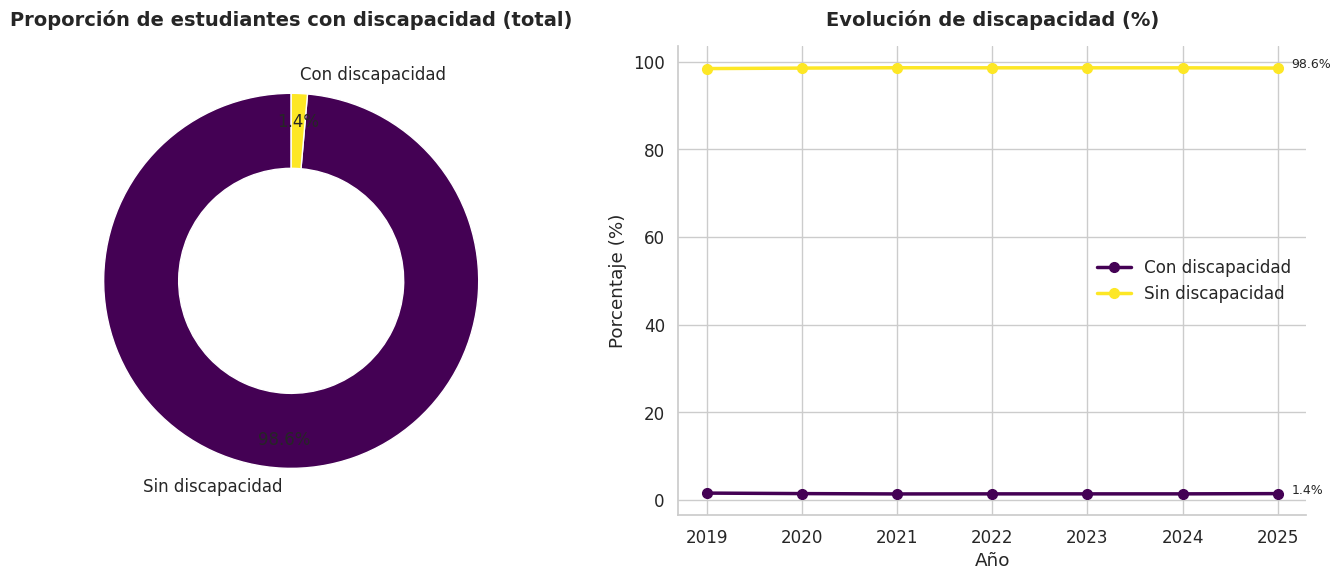


Tabla resumen - Discapacidad por año:


,Con discapacidad (n),Con discapacidad (%),Sin discapacidad (n),Sin discapacidad (%)
Año,,,,
2019,543,1.5%,"35,136",98.5%
2020,524,1.4%,"36,680",98.6%
2021,480,1.3%,"35,627",98.7%
2022,480,1.3%,"35,142",98.7%
2023,458,1.3%,"33,565",98.7%
2024,453,1.3%,"33,136",98.7%
2025,458,1.4%,"32,149",98.6%


In [14]:
# --- Distribución general y evolución temporal ---
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

disc_conteo = SIMAT['DISCAPACIDAD'].value_counts()
n_cats_d = len(disc_conteo)
colores_disc = [palette[int(i * (len(palette)-1) / max(n_cats_d-1, 1))] for i in range(n_cats_d)]
axes[0].pie(disc_conteo, labels=disc_conteo.index,
            autopct='%1.1f%%', colors=colores_disc, startangle=90,
            textprops={'fontsize': 12}, pctdistance=0.85,
            wedgeprops=dict(width=0.4, edgecolor='white'))
axes[0].set_title('Proporción de estudiantes con discapacidad (total)', fontsize=14, fontweight='bold', pad=15)

disc_anual = SIMAT.groupby(['ANO_INF', 'DISCAPACIDAD']).size().unstack(fill_value=0)
disc_pct = disc_anual.div(disc_anual.sum(axis=1), axis=0) * 100

n_cats_dt = len(disc_pct.columns)
colores_disc_t = [palette[int(i * (len(palette)-1) / max(n_cats_dt-1, 1))] for i in range(n_cats_dt)]

for i, col in enumerate(disc_pct.columns):
    axes[1].plot(disc_pct.index, disc_pct[col], marker='o', linewidth=2.5,
                 markersize=7, label=col, color=colores_disc_t[i])
    ultimo = disc_pct[col].iloc[-1]
    axes[1].annotate(f'{ultimo:.1f}%', (disc_pct.index[-1], ultimo),
                     textcoords='offset points', xytext=(10, 0), fontsize=9)

axes[1].set_title('Evolución de discapacidad (%)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticks(sorted(SIMAT['ANO_INF'].unique()))
axes[1].legend(frameon=False)
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

print("\nTabla resumen - Discapacidad por año:")
display(tabla_resumen(SIMAT, 'DISCAPACIDAD'))

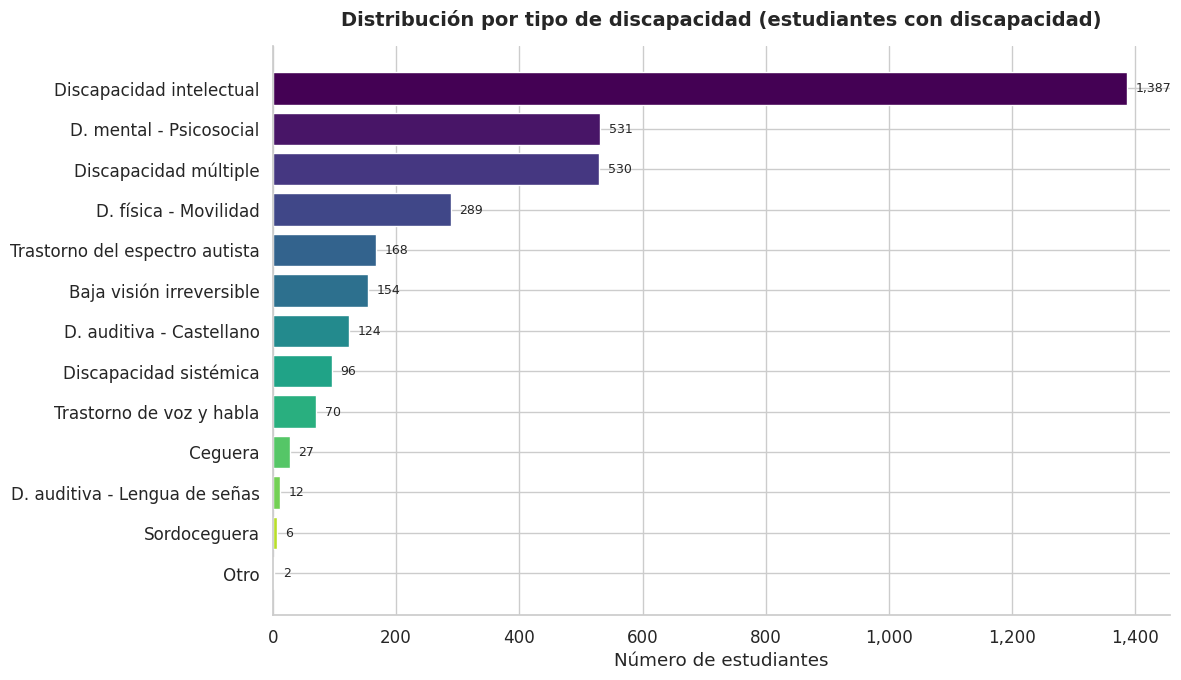


Distribución por tipo de discapacidad y año:


,Baja visión irreversible (n),Baja visión irreversible (%),Ceguera (n),Ceguera (%),D. auditiva - Castellano (n),D. auditiva - Castellano (%),D. auditiva - Lengua de señas (n),D. auditiva - Lengua de señas (%),D. física - Movilidad (n),D. física - Movilidad (%),...,Discapacidad sistémica (n),Discapacidad sistémica (%),Otro (n),Otro (%),Sordoceguera (n),Sordoceguera (%),Trastorno de voz y habla (n),Trastorno de voz y habla (%),Trastorno del espectro autista (n),Trastorno del espectro autista (%)
Año,,,,,,,,,,,,,,,,,,,,,
2019,29,5.3%,3,0.6%,14,2.6%,3,0.6%,40,7.4%,...,58,10.7%,0,0.0%,0,0.0%,36,6.6%,10,1.8%
2020,23,4.4%,8,1.5%,14,2.7%,3,0.6%,46,8.8%,...,23,4.4%,2,0.4%,1,0.2%,15,2.9%,9,1.7%
2021,19,4.0%,7,1.5%,17,3.5%,3,0.6%,44,9.2%,...,11,2.3%,0,0.0%,1,0.2%,6,1.2%,12,2.5%
2022,20,4.2%,5,1.0%,22,4.6%,2,0.4%,44,9.2%,...,3,0.6%,0,0.0%,2,0.4%,5,1.0%,19,4.0%
2023,20,4.4%,2,0.4%,21,4.6%,0,0.0%,40,8.7%,...,1,0.2%,0,0.0%,2,0.4%,5,1.1%,30,6.6%
2024,18,4.0%,1,0.2%,21,4.6%,0,0.0%,36,7.9%,...,0,0.0%,0,0.0%,0,0.0%,3,0.7%,38,8.4%
2025,25,5.5%,1,0.2%,15,3.3%,1,0.2%,39,8.5%,...,0,0.0%,0,0.0%,0,0.0%,0,0.0%,50,10.9%


In [15]:
# --- Distribución por tipo de discapacidad (solo estudiantes con discapacidad) ---
# Diccionario de tipos de discapacidad
dict_discapacidad = {
    3: 'Baja visión irreversible',
    4: 'Ceguera',
    7: 'Trastorno del espectro autista',
    8: 'Discapacidad intelectual',
    10: 'Discapacidad múltiple',
    12: 'D. auditiva - Lengua de señas',
    13: 'D. auditiva - Castellano',
    14: 'Sordoceguera',
    15: 'D. física - Movilidad',
    17: 'Discapacidad sistémica',
    18: 'D. mental - Psicosocial',
    19: 'Trastorno de voz y habla',
}

# Filtrar solo estudiantes con discapacidad
df_disc = SIMAT[SIMAT['TIPO_DISCAPACIDAD'] != 99].copy()
df_disc['TIPO_DISC_NOMBRE'] = df_disc['TIPO_DISCAPACIDAD'].map(dict_discapacidad).fillna('Otro')

# Conteo general
conteo_tipo = df_disc['TIPO_DISC_NOMBRE'].value_counts()

fig, ax = plt.subplots(figsize=(12, 7))
n_barras = len(conteo_tipo)
colores = [palette[int(i * (len(palette)-1) / max(n_barras-1, 1))] for i in range(n_barras)]
bars = ax.barh(conteo_tipo.index[::-1], conteo_tipo.values[::-1], color=colores[::-1], edgecolor='white')

for bar, val in zip(bars, conteo_tipo.values[::-1]):
    ax.text(val + conteo_tipo.max()*0.01, bar.get_y() + bar.get_height()/2,
            f'{int(val):,}', va='center', fontsize=9)

ax.set_title('Distribución por tipo de discapacidad (estudiantes con discapacidad)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Número de estudiantes')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen por tipo de discapacidad y año
print('\nDistribución por tipo de discapacidad y año:')
display(tabla_resumen(df_disc, 'TIPO_DISC_NOMBRE'))

---
## 10. Distribución Étnica

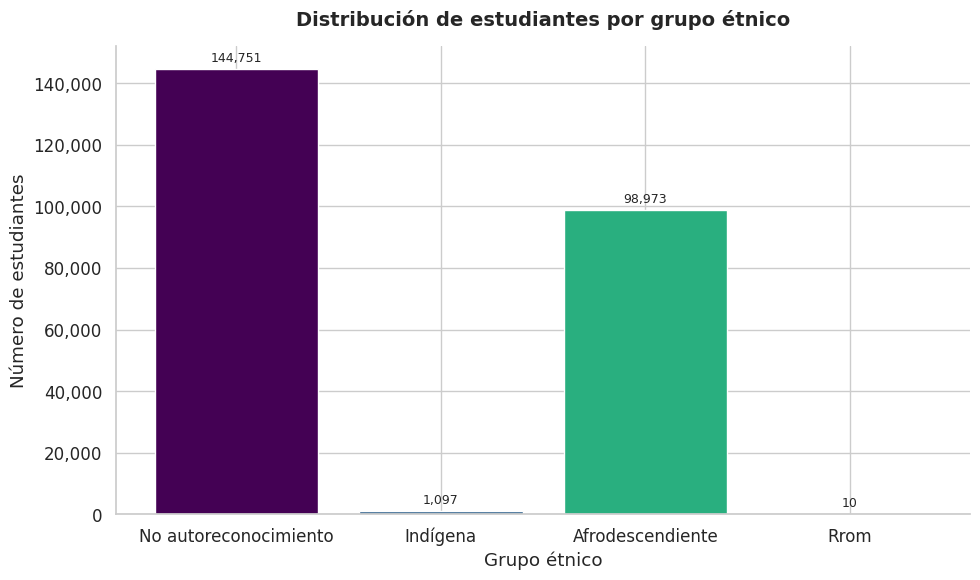


Tabla resumen - Etnia por año:


,Afrodescendiente (n),Afrodescendiente (%),Indígena (n),Indígena (%),No autoreconocimiento (n),No autoreconocimiento (%),Rrom (n),Rrom (%)
Año,,,,,,,,
2019,"16,810",47.1%,201,0.6%,"18,666",52.3%,2,0.0%
2020,"15,736",42.3%,176,0.5%,"21,290",57.2%,2,0.0%
2021,"14,434",40.0%,167,0.5%,"21,504",59.6%,2,0.0%
2022,"13,423",37.7%,157,0.4%,"22,041",61.9%,1,0.0%
2023,"12,739",37.4%,136,0.4%,"21,147",62.2%,1,0.0%
2024,"13,297",39.6%,125,0.4%,"20,166",60.0%,1,0.0%
2025,"12,534",38.4%,135,0.4%,"19,937",61.1%,1,0.0%


In [16]:
orden_etnia = ['No autoreconocimiento', 'Indígena', 'Afrodescendiente', 'Rrom']

# --- Distribución general ---
fig, ax = plt.subplots(figsize=(10, 6))
grafico_barras(SIMAT, 'ETNIA_CAT', 'Distribución de estudiantes por grupo étnico',
               'Grupo étnico', orden=orden_etnia, ax=ax)
plt.show()

# --- Tabla resumen ---
print("\nTabla resumen - Etnia por año:")
display(tabla_resumen(SIMAT, 'ETNIA_CAT'))

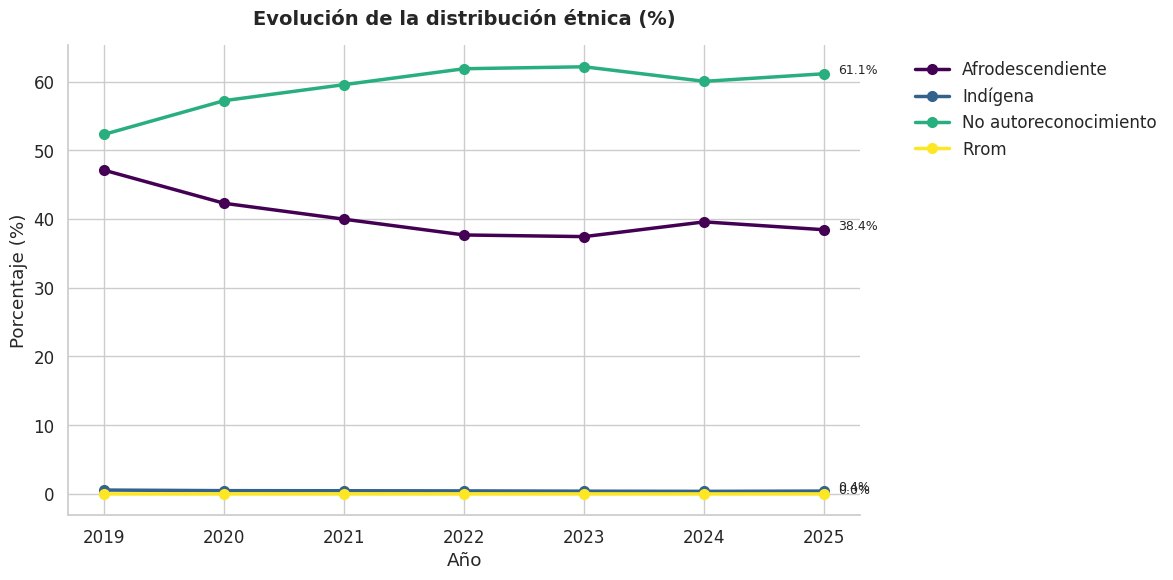

In [17]:
# --- Evolución temporal (porcentaje) ---
grafico_lineas_temporal(SIMAT, 'ETNIA_CAT',
                        'Evolución de la distribución étnica (%)',
                        porcentaje=True)

---
## 11. Distribución por Grado y Nivel Educativo

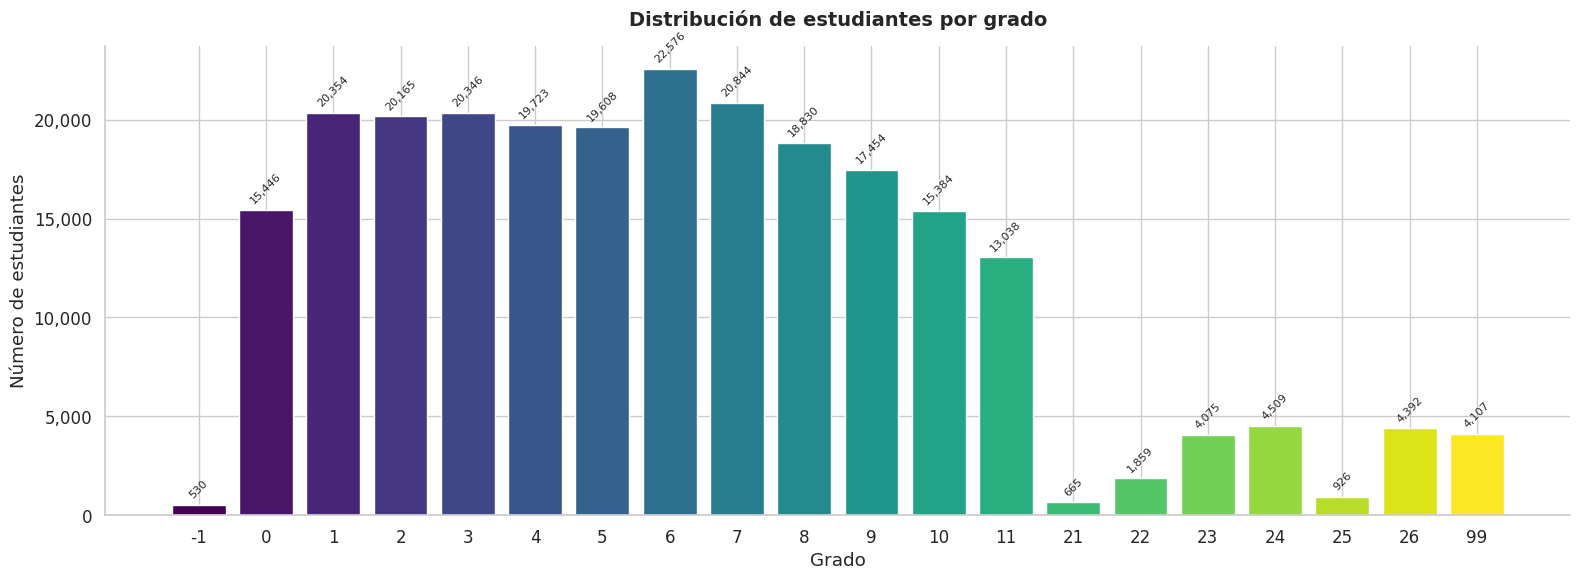

In [18]:
# --- Distribución por grado ---
grados_orden = [-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 21, 22, 23, 24, 25, 26, 99]
grado_conteo = SIMAT['GRADO'].value_counts().reindex(grados_orden).dropna()

fig, ax = plt.subplots(figsize=(16, 6))
n_barras = len(grado_conteo)
colores = [palette[int(i * (len(palette)-1) / max(n_barras-1, 1))] for i in range(n_barras)]
bars = ax.bar(grado_conteo.index.astype(str), grado_conteo.values, color=colores, edgecolor='white')

for bar, val in zip(bars, grado_conteo.values):
    ax.text(bar.get_x() + bar.get_width()/2, val + grado_conteo.max()*0.01,
            f'{int(val):,}', ha='center', va='bottom', fontsize=8, rotation=45)

ax.set_title('Distribución de estudiantes por grado', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Grado')
ax.set_ylabel('Número de estudiantes')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(formato_miles))
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

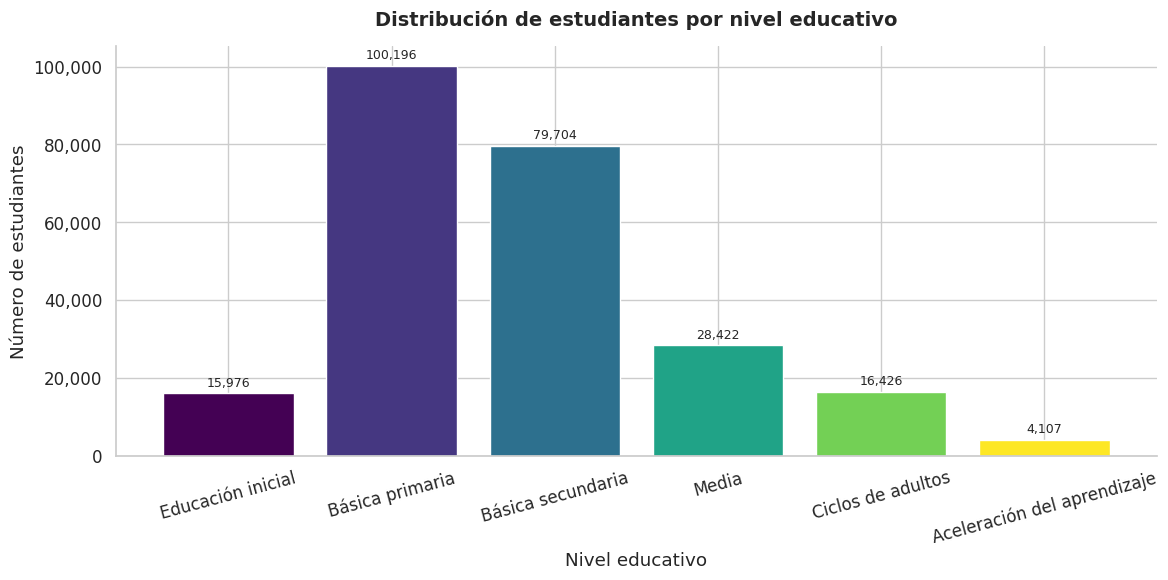


Tabla resumen - Nivel educativo por año:


,Aceleración del aprendizaje (n),Aceleración del aprendizaje (%),Básica primaria (n),Básica primaria (%),Básica secundaria (n),Básica secundaria (%),Ciclos de adultos (n),Ciclos de adultos (%),Educación inicial (n),Educación inicial (%),Media (n),Media (%)
Año,,,,,,,,,,,,
2019,767,2.1%,"14,151",39.7%,"12,168",34.1%,"2,551",7.1%,"2,106",5.9%,"3,936",11.0%
2020,754,2.0%,"14,462",38.9%,"12,614",33.9%,"2,840",7.6%,"2,326",6.3%,"4,208",11.3%
2021,575,1.6%,"14,326",39.7%,"12,200",33.8%,"2,192",6.1%,"2,383",6.6%,"4,431",12.3%
2022,602,1.7%,"14,283",40.1%,"11,506",32.3%,"2,545",7.1%,"2,498",7.0%,"4,188",11.8%
2023,628,1.8%,"14,161",41.6%,"10,654",31.3%,"2,211",6.5%,"2,315",6.8%,"4,054",11.9%
2024,431,1.3%,"14,474",43.1%,"10,371",30.9%,"2,174",6.5%,"2,291",6.8%,"3,848",11.5%
2025,350,1.1%,"14,339",44.0%,"10,191",31.3%,"1,913",5.9%,"2,057",6.3%,"3,757",11.5%


In [19]:
# --- Distribución por nivel educativo ---
orden_nivel = ['Educación inicial', 'Básica primaria', 'Básica secundaria', 'Media',
               'Ciclos de adultos', 'Aceleración del aprendizaje']

fig, ax = plt.subplots(figsize=(12, 6))
grafico_barras(SIMAT, 'NIVEL_EDUCATIVO', 'Distribución de estudiantes por nivel educativo',
               'Nivel educativo', orden=orden_nivel, ax=ax, rotation=15)
plt.show()

# --- Tabla resumen ---
print("\nTabla resumen - Nivel educativo por año:")
display(tabla_resumen(SIMAT, 'NIVEL_EDUCATIVO'))

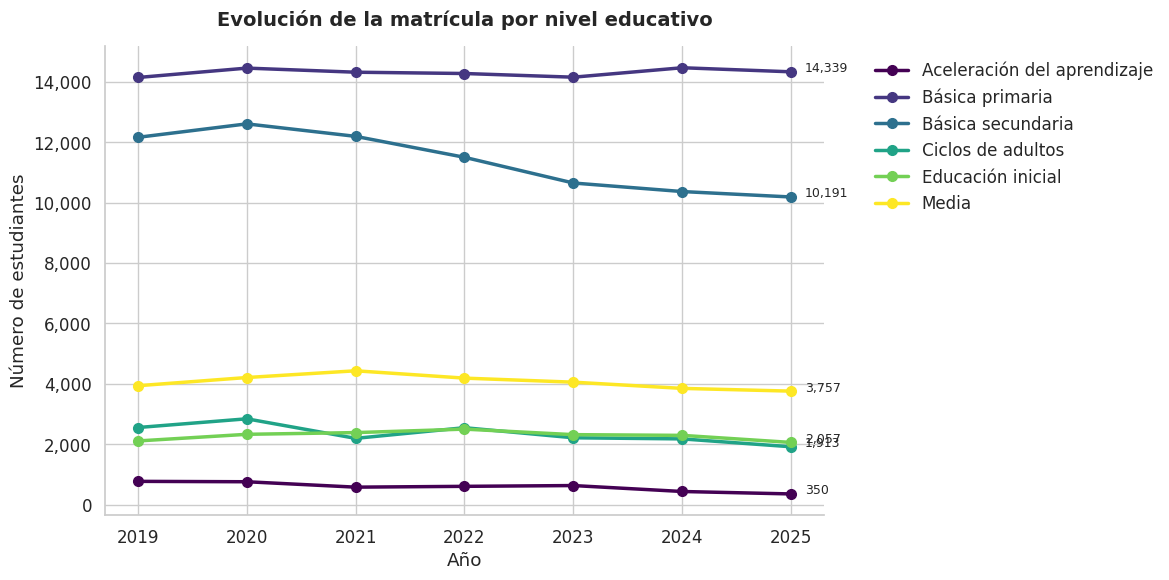

In [20]:
# --- Evolución temporal por nivel educativo ---
grafico_lineas_temporal(SIMAT, 'NIVEL_EDUCATIVO',
                        'Evolución de la matrícula por nivel educativo',
                        porcentaje=False)

---
## 12. Cabeza de Familia y Beneficiario Madre Cabeza de Familia

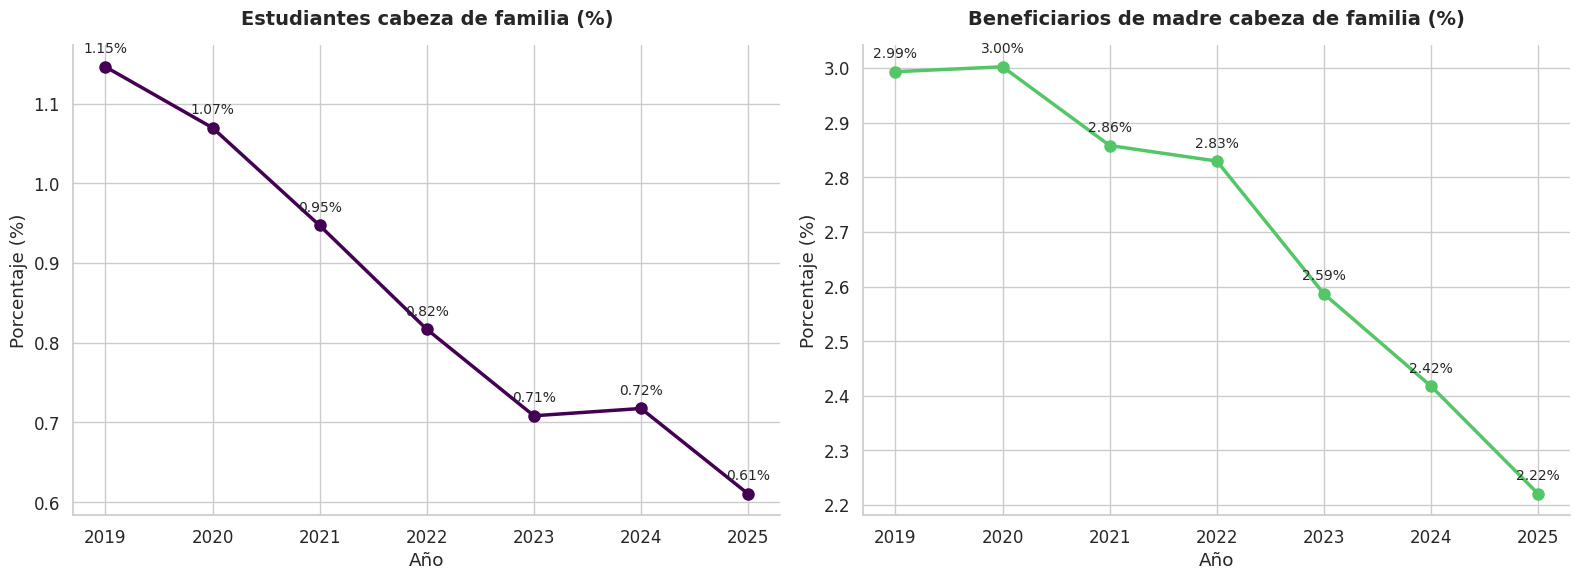


Tabla resumen - Cabeza de familia por año:


,N (n),N (%),S (n),S (%)
Año,,,,
2019,"35,270",98.9%,409,1.1%
2020,"36,806",98.9%,398,1.1%
2021,"35,765",99.1%,342,0.9%
2022,"35,331",99.2%,291,0.8%
2023,"33,782",99.3%,241,0.7%
2024,"33,348",99.3%,241,0.7%
2025,"32,408",99.4%,199,0.6%



Tabla resumen - Beneficiario madre cabeza de familia por año:


,N (n),N (%),S (n),S (%)
Año,,,,
2019,"34,611",97.0%,"1,068",3.0%
2020,"36,087",97.0%,"1,117",3.0%
2021,"35,075",97.1%,"1,032",2.9%
2022,"34,614",97.2%,"1,008",2.8%
2023,"33,143",97.4%,880,2.6%
2024,"32,777",97.6%,812,2.4%
2025,"31,883",97.8%,724,2.2%


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Cabeza de familia ---
cab_anual = SIMAT.groupby('ANO_INF').apply(
    lambda df: (df['CAB_FAMILIA'] == 'S').sum() / len(df) * 100
).reset_index(name='Porcentaje')

axes[0].plot(cab_anual['ANO_INF'], cab_anual['Porcentaje'], marker='o', linewidth=2.5,
             markersize=8, color=palette[0])
for _, row in cab_anual.iterrows():
    axes[0].annotate(f'{row["Porcentaje"]:.2f}%', (row['ANO_INF'], row['Porcentaje']),
                     textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10)

axes[0].set_title('Estudiantes cabeza de familia (%)', fontsize=14, fontweight='bold', pad=15)
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Porcentaje (%)')
axes[0].set_xticks(sorted(SIMAT['ANO_INF'].unique()))
axes[0].spines[['top', 'right']].set_visible(False)

# --- Beneficiario madre cabeza de familia ---
ben_anual = SIMAT.groupby('ANO_INF').apply(
    lambda df: (df['BEN_MAD_FLIA'] == 'S').sum() / len(df) * 100
).reset_index(name='Porcentaje')

axes[1].plot(ben_anual['ANO_INF'], ben_anual['Porcentaje'], marker='o', linewidth=2.5,
             markersize=8, color=palette[14])
for _, row in ben_anual.iterrows():
    axes[1].annotate(f'{row["Porcentaje"]:.2f}%', (row['ANO_INF'], row['Porcentaje']),
                     textcoords='offset points', xytext=(0, 10), ha='center', fontsize=10)

axes[1].set_title('Beneficiarios de madre cabeza de familia (%)', fontsize=14, fontweight='bold', pad=15)
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Porcentaje (%)')
axes[1].set_xticks(sorted(SIMAT['ANO_INF'].unique()))
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

# Tablas resumen
print("\nTabla resumen - Cabeza de familia por año:")
display(tabla_resumen(SIMAT, 'CAB_FAMILIA'))
print("\nTabla resumen - Beneficiario madre cabeza de familia por año:")
display(tabla_resumen(SIMAT, 'BEN_MAD_FLIA'))

---
## 13. Índices de Eficiencia Educativa

Los índices de eficiencia educativa se componen de:
- **Índice de deserción**: Desertores (SIMPADE) / Matrícula (SIMAT) × 100
- **Índice de repitencia**: Repitentes / Matrícula × 100
- **Índice de aprobación**: 100% - Deserción - Repitencia

Se calculan desde 2020 en adelante (disponibilidad de SIMPADE).

Índices de eficiencia educativa calculados:


,ANO,MATRICULA,DESERTORES,REPITENTES,IND_DESERCION,IND_REPITENCIA,IND_APROBACION
0,2020,37204,603,2963,1.62,7.96,90.42
1,2021,36107,1557,2696,4.31,7.47,88.22
2,2022,35622,1980,3119,5.56,8.76,85.68
3,2023,34023,1999,4233,5.88,12.44,81.68
4,2024,33589,2010,5011,5.98,14.92,79.10
5,2025,32607,1809,3672,5.55,11.26,83.19


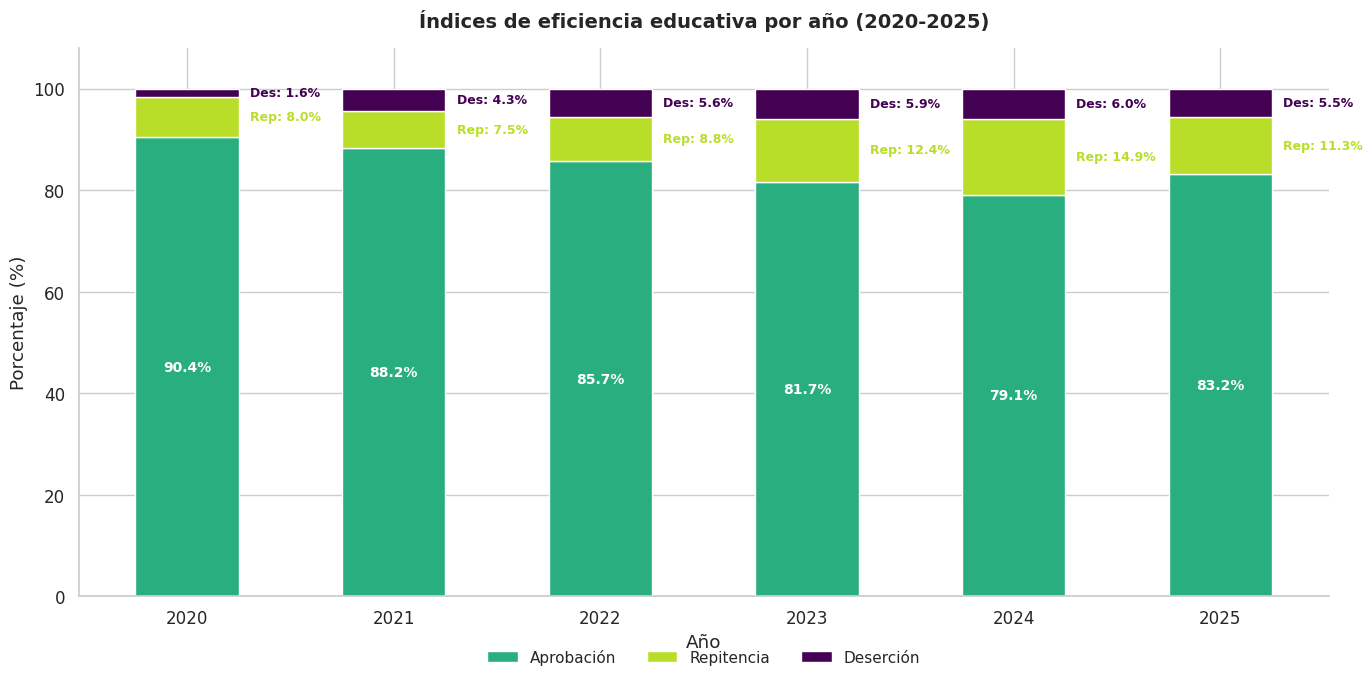

In [23]:
# ============================================================
# Cálculo de los tres índices de eficiencia educativa
# ============================================================

# --- Deserción: SIMPADE / SIMAT (por año, desde 2020) ---
simat_2020 = SIMAT[SIMAT['ANO_INF'] >= 2020].copy()

matricula_sede = simat_2020.groupby(['DANE_ANTERIOR', 'ANO_INF']).size().reset_index(name='MATRICULA')
matricula_sede.columns = ['DANE_SEDE', 'ANO', 'MATRICULA']

desercion_sede = SIMPADE.groupby(['SPD_DANE_SEDE', 'ANNO_INF']).size().reset_index(name='DESERTORES')
desercion_sede.columns = ['DANE_SEDE', 'ANO', 'DESERTORES']

indices = matricula_sede.groupby('ANO').agg(MATRICULA=('MATRICULA', 'sum')).reset_index()
des_anual = desercion_sede.groupby('ANO').agg(DESERTORES=('DESERTORES', 'sum')).reset_index()
indices = indices.merge(des_anual, on='ANO', how='left')
indices['DESERTORES'] = indices['DESERTORES'].fillna(0).astype(int)

# --- Repitencia por año (desde 2020) ---
rep_anual = simat_2020.groupby('ANO_INF').apply(
    lambda df: (df['REPITENTE'] == 'S').sum()
).reset_index(name='REPITENTES')
rep_anual.columns = ['ANO', 'REPITENTES']
indices = indices.merge(rep_anual, on='ANO', how='left')

# --- Cálculo de índices ---
indices['IND_DESERCION'] = (indices['DESERTORES'] / indices['MATRICULA'] * 100).round(2)
indices['IND_REPITENCIA'] = (indices['REPITENTES'] / indices['MATRICULA'] * 100).round(2)
indices['IND_APROBACION'] = (100 - indices['IND_DESERCION'] - indices['IND_REPITENCIA']).round(2)

print('Índices de eficiencia educativa calculados:')
display(indices)

# ============================================================
# Visualización: Barras apiladas
# ============================================================
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(indices))
w = 0.5

c_aprobacion = palette[12]   # verde
c_repitencia = palette[17]   # amarillo
c_desercion = palette[0]     # morado oscuro

bars1 = ax.bar(x, indices['IND_APROBACION'], w, label='Aprobación', color=c_aprobacion, edgecolor='white')
bars2 = ax.bar(x, indices['IND_REPITENCIA'], w, bottom=indices['IND_APROBACION'],
               label='Repitencia', color=c_repitencia, edgecolor='white')
bars3 = ax.bar(x, indices['IND_DESERCION'], w,
               bottom=indices['IND_APROBACION'] + indices['IND_REPITENCIA'],
               label='Deserción', color=c_desercion, edgecolor='white')

for i in range(len(indices)):
    # Aprobación centrada
    y_ap = indices['IND_APROBACION'].iloc[i] / 2
    ax.text(x[i], y_ap, f"{indices['IND_APROBACION'].iloc[i]:.1f}%",
            ha='center', va='center', fontsize=10, fontweight='bold', color='white')
    # Repitencia a la derecha
    y_rep = indices['IND_APROBACION'].iloc[i] + indices['IND_REPITENCIA'].iloc[i] / 2
    ax.annotate(f"Rep: {indices['IND_REPITENCIA'].iloc[i]:.1f}%",
                xy=(x[i] + w/2, y_rep), xytext=(8, 0),
                textcoords='offset points', ha='left', va='center', fontsize=9,
                color=c_repitencia, fontweight='bold')
    # Deserción a la derecha
    y_des = indices['IND_APROBACION'].iloc[i] + indices['IND_REPITENCIA'].iloc[i] + indices['IND_DESERCION'].iloc[i] / 2
    ax.annotate(f"Des: {indices['IND_DESERCION'].iloc[i]:.1f}%",
                xy=(x[i] + w/2, y_des), xytext=(8, 0),
                textcoords='offset points', ha='left', va='center', fontsize=9,
                color=c_desercion, fontweight='bold')

ax.set_title('Índices de eficiencia educativa por año (2020-2025)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Año')
ax.set_ylabel('Porcentaje (%)')
ax.set_xticks(x)
ax.set_xticklabels(indices['ANO'].astype(str))
ax.set_ylim(0, 108)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=False, fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

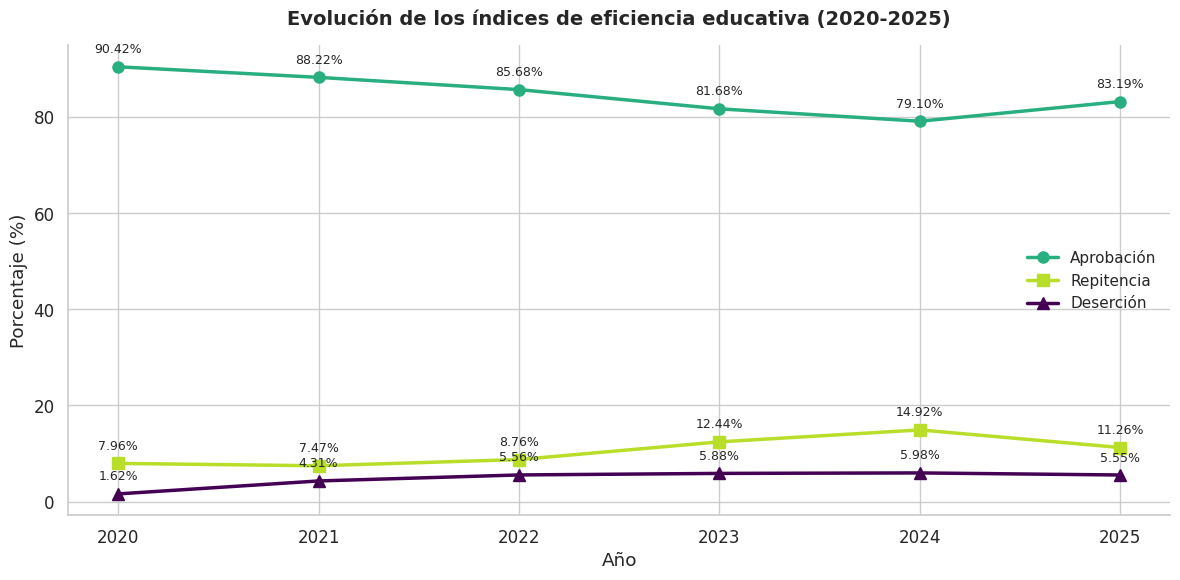


Tabla resumen - Índices de eficiencia educativa:


,Matrícula,Desertores,Repitentes,Índice deserción,Índice repitencia,Índice aprobación
ANO,,,,,,
2020,"37,204",603,"2,963",1.62%,7.96%,90.42%
2021,"36,107","1,557","2,696",4.31%,7.47%,88.22%
2022,"35,622","1,980","3,119",5.56%,8.76%,85.68%
2023,"34,023","1,999","4,233",5.88%,12.44%,81.68%
2024,"33,589","2,010","5,011",5.98%,14.92%,79.10%
2025,"32,607","1,809","3,672",5.55%,11.26%,83.19%


In [24]:
# ============================================================
# Evolución de cada índice (gráfico de líneas)
# ============================================================
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(indices['ANO'], indices['IND_APROBACION'], marker='o', linewidth=2.5,
        markersize=8, label='Aprobación', color=palette[12])
ax.plot(indices['ANO'], indices['IND_REPITENCIA'], marker='s', linewidth=2.5,
        markersize=8, label='Repitencia', color=palette[17])
ax.plot(indices['ANO'], indices['IND_DESERCION'], marker='^', linewidth=2.5,
        markersize=8, label='Deserción', color=palette[0])

for col, offset in [('IND_APROBACION', 1.5), ('IND_REPITENCIA', -1.5), ('IND_DESERCION', -1.5)]:
    for _, row in indices.iterrows():
        ax.annotate(f"{row[col]:.2f}%", (row['ANO'], row[col]),
                    textcoords='offset points', xytext=(0, 10), ha='center', fontsize=9)

ax.set_title('Evolución de los índices de eficiencia educativa (2020-2025)',
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Año')
ax.set_ylabel('Porcentaje (%)')
ax.set_xticks(indices['ANO'])
ax.legend(frameon=False, fontsize=11)
ax.spines[['top', 'right']].set_visible(False)
plt.tight_layout()
plt.show()

# Tabla resumen
print('\nTabla resumen - Índices de eficiencia educativa:')
tabla_ef = indices.set_index('ANO').copy()
tabla_ef['MATRICULA'] = tabla_ef['MATRICULA'].apply(lambda x: f'{int(x):,}')
tabla_ef['DESERTORES'] = tabla_ef['DESERTORES'].apply(lambda x: f'{int(x):,}')
tabla_ef['REPITENTES'] = tabla_ef['REPITENTES'].apply(lambda x: f'{int(x):,}')
tabla_ef['IND_DESERCION'] = tabla_ef['IND_DESERCION'].apply(lambda x: f'{x:.2f}%')
tabla_ef['IND_REPITENCIA'] = tabla_ef['IND_REPITENCIA'].apply(lambda x: f'{x:.2f}%')
tabla_ef['IND_APROBACION'] = tabla_ef['IND_APROBACION'].apply(lambda x: f'{x:.2f}%')
tabla_ef.columns = ['Matrícula', 'Desertores', 'Repitentes',
                     'Índice deserción', 'Índice repitencia', 'Índice aprobación']
display(tabla_ef)

---
## 14. Resumen general

In [25]:
# Resumen consolidado del último año disponible
ultimo_ano = SIMAT['ANO_INF'].max()
df_ultimo = SIMAT[SIMAT['ANO_INF'] == ultimo_ano]

print(f"{'='*60}")
print(f"RESUMEN DEL AÑO {ultimo_ano}")
print(f"{'='*60}")
print(f"Total matrícula: {len(df_ultimo):,}")
print(f"\n--- Género ---")
for g, n in df_ultimo['GENERO'].value_counts().items():
    label = 'Femenino' if g == 'F' else 'Masculino'
    print(f"  {label}: {n:,} ({n/len(df_ultimo)*100:.1f}%)")

print(f"\n--- Edad ---")
edades = df_ultimo['EDAD'].dropna()
print(f"  Media: {edades.mean():.1f} años | Mediana: {edades.median():.0f} años")

print(f"\n--- Estrato ---")
for e in ['No aplica', 'Estrato 1', 'Estrato 2', 'Estrato 3', 'Estrato 4', 'Estrato 5', 'Estrato 6']:
    n = (df_ultimo['ESTRATO_CAT'] == e).sum()
    if n > 0:
        print(f"  {e}: {n:,} ({n/len(df_ultimo)*100:.1f}%)")

print(f"\n--- Víctimas del conflicto ---")
n_vict = (df_ultimo['VICTIMA'] == 'Víctima').sum()
print(f"  Víctimas: {n_vict:,} ({n_vict/len(df_ultimo)*100:.1f}%)")

print(f"\n--- Discapacidad ---")
n_disc = (df_ultimo['DISCAPACIDAD'] == 'Con discapacidad').sum()
print(f"  Con discapacidad: {n_disc:,} ({n_disc/len(df_ultimo)*100:.1f}%)")

print(f"\n--- Etnia ---")
for e in ['No autoreconocimiento', 'Indígena', 'Afrodescendiente', 'Rrom']:
    n = (df_ultimo['ETNIA_CAT'] == e).sum()
    print(f"  {e}: {n:,} ({n/len(df_ultimo)*100:.1f}%)")

print(f"\n--- Repitencia ---")
n_rep = (df_ultimo['REPITENTE'] == 'S').sum()
print(f"  Repitentes: {n_rep:,} ({n_rep/len(df_ultimo)*100:.2f}%)")

print(f"\n--- Cabeza de familia ---")
n_cab = (df_ultimo['CAB_FAMILIA'] == 'S').sum()
print(f"  Cabeza de familia: {n_cab:,} ({n_cab/len(df_ultimo)*100:.2f}%)")

n_ben = (df_ultimo['BEN_MAD_FLIA'] == 'S').sum()
print(f"  Beneficiario madre cabeza de familia: {n_ben:,} ({n_ben/len(df_ultimo)*100:.2f}%)")

RESUMEN DEL AÑO 2025
Total matrícula: 32,607

--- Género ---
  Femenino: 16,710 (51.2%)
  Masculino: 15,897 (48.8%)

--- Edad ---
  Media: 12.6 años | Mediana: 12 años

--- Estrato ---
  No aplica: 1,596 (4.9%)
  Estrato 1: 15,525 (47.6%)
  Estrato 2: 13,066 (40.1%)
  Estrato 3: 2,345 (7.2%)
  Estrato 4: 62 (0.2%)
  Estrato 5: 11 (0.0%)
  Estrato 6: 2 (0.0%)

--- Víctimas del conflicto ---
  Víctimas: 0 (0.0%)

--- Discapacidad ---
  Con discapacidad: 458 (1.4%)

--- Etnia ---
  No autoreconocimiento: 19,937 (61.1%)
  Indígena: 135 (0.4%)
  Afrodescendiente: 12,534 (38.4%)
  Rrom: 1 (0.0%)

--- Repitencia ---
  Repitentes: 3,672 (11.26%)

--- Cabeza de familia ---
  Cabeza de familia: 199 (0.61%)
  Beneficiario madre cabeza de familia: 724 (2.22%)
